In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
from scipy.stats import rv_continuous
from scipy.special import gamma
from scipy.interpolate import interp1d
import numpy as np
import emcee
from mpl_toolkits.axes_grid1 import make_axes_locatable
from numpy import exp, sqrt
from scipy.integrate import quad, dblquad
import matplotlib.patches as patches
from scipy.integrate import simps
import scipy.optimize as optimize
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.neighbors import KDTree
import sys
import lmfit
from py_unsio import *
import pymc
import os
from pymodelfit import FunctionModel1DAuto
import wkbl
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
import wkbl.astro.nbody_essentials as nbe
import cfalcon
CF =cfalcon.CFalcon()
import iminuit
from iminuit import Minuit, describe, Struct
import probfit
import warnings
from matplotlib.ticker import FormatStrFormatter
warnings.filterwarnings('ignore')

In [6]:
pathsim = "/data/POL/HALOB/hydro/output_00417"
#path = "/media/arturo/ARTUROTECA/OUTPUTS/HaloB/output_00417"
myhalo = wkbl.Galaxy_Hound(pathsim,"halo,stars,gas")
print myhalo.dm.pos3d[:,0].max()-myhalo.dm.pos3d[:,0].min()
print myhalo.dm.pos3d[:,1].max()-myhalo.dm.pos3d[:,1].min()
print myhalo.dm.pos3d[:,2].max()-myhalo.dm.pos3d[:,2].min()


loading Dark matter..
loading Stars..
loading Gas..
19915.796831674874
19915.793949041516
19915.801059083315


In [4]:
print myhalo.dm.mass.min()

230812.75


In [5]:
ok,rho,_= CF.getDensity(np.array(myhalo.st.pos3d.reshape(len(myhalo.st.pos3d)*3),dtype=np.float32), myhalo.st.mass)
centro_rho = myhalo.st.pos3d[np.where(rho == rho.max())][0]
print "density",centro_rho
myhalo.center_shift(centro_rho)

density [-0.05960974 -1.06715898 -1.40904299]


In [6]:
myhalo.r_virial(600,n=25)

starting
stackted
start histogram
 done
rotated
| r_200 = 166.9921875
| Diagonal matrix computed 
|    |19, 0, 0|
| D =| 0,14, 0|
|    | 0, 0, 2|


In [7]:
pos_dm = np.array(myhalo.dm.pos3d.reshape(len(myhalo.dm.pos3d)*3),dtype=np.float32)
pos_gs = np.array(myhalo.gs.pos3d.reshape(len(myhalo.gs.pos3d)*3),dtype=np.float32)
pos_st = np.array(myhalo.st.pos3d.reshape(len(myhalo.st.pos3d)*3),dtype=np.float32)
pos = np.concatenate((pos_dm, pos_st, pos_gs))
mass = np.concatenate((myhalo.dm.mass,myhalo.st.mass,myhalo.gs.mass))
v = np.concatenate((myhalo.dm.v,myhalo.st.v,myhalo.gs.v))
print len(mass)*3, len(pos)
pos3d = pos.reshape(len(pos)/3,3)
r2 = pos3d[:,0]**2 + pos3d[:,1]**2 +pos3d[:,2]**2

165812748 165812748


In [8]:
ok, acc, Phy = CF.getGravity(pos,mass,0.15,G=myhalo.p.G)
Phy = Phy * myhalo.p.kpctokm**2

In [9]:
print len(myhalo.dm.r[(myhalo.dm.r>7.5)&(myhalo.dm.r<8.5)])

32675


 #  Rmax from max of potential
 # (spherical and/or line of sight of the neighbor galaxy)
 
 
 ### Spherical
    

In [10]:

bin_num = 512

pot_sph, bins_pot = np.histogram(r2,bins=bin_num,
                                 weights=Phy)
n, _ = np.histogram(r2,bins=bin_num)



In [11]:
bins_pot = np.linspace(0.,myhalo.dm.r.max(),512)
print bins_pot.max()

4174.794762920974


In [12]:
bins_pot = np.linspace(0.,myhalo.dm.r.max(),512)
mean_phi = np.array([])
std_phi = np.array([])
r_phi = np.array([])
for i in range(len(bins_pot)-1):
    contidion = (r2>bins_pot[i]**2)&(r2<bins_pot[i+1]**2)
    
    mean_phi = np.append(mean_phi,np.average(Phy[contidion]))
    std_phi = np.append(std_phi,np.std((Phy[contidion])))
    r_phi = np.append(r_phi, ((bins_pot[i])+(bins_pot[i+1]))/2)
    
    

<IPython.core.display.Javascript object>


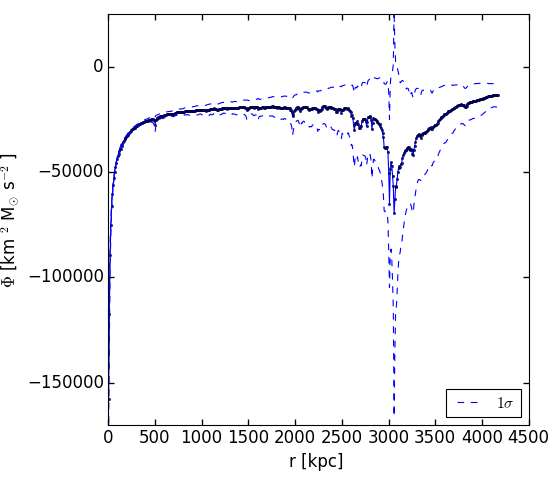

In [13]:
fig, ax = plt.subplots(figsize=[7,6])
#ax.set_title("spherical shells",fontsize=30)
ax.set_ylim([-17e4,25e3])
ax.set_xlim([0,4500])

ax.set_ylabel(r'$\Phi$ [km $^2$ M$_{\odot}$ s$^{-2}$ ] ', fontsize=15)
#ax.set_xscale('log')
ax.set_xlabel(r'r [kpc] ', fontsize=15)
ax.plot(r_phi,mean_phi,'bo-',markersize=2)
ax.plot(r_phi,mean_phi+std_phi,'b--')
ax.plot(r_phi,mean_phi-std_phi,'b--',label=r"$1 \sigma$")

legend = ax.legend(loc='lower right', ncol=1, shadow=False, fontsize=14)
frame = legend.get_frame()
#fig.text(0.75,0.7,pathsim[10:14]+" "+pathsim[14],fontsize=18)
#ax.add_patch(
#    patches.Rectangle((450, -1.5e4),
#        100,
#        1e4,
#        fill=False      # remove background
#    )
#)

"""
left, bottom, width, height = [0.45, 0.23, 0.4, 0.4]
ax2 = fig.add_axes([left, bottom, width, height])
ax2.set_xlim([450,550])
ax2.set_ylim([-1.5e4,-5e3])

ax2.set_ylabel(r'$\Phi$ [kpc $^2$ M$_{\odot}$ s$^{-2}$ ] ', fontsize=15)
ax2.set_xlabel(r'r [kpc] ', fontsize=15)
ax2.plot(r_phi,mean_phi,'bo-',markersize=2)
ax2.plot(r_phi,mean_phi+std_phi,'b--')
ax2.plot(r_phi,mean_phi-std_phi,'b--')
"""
fig.tight_layout(w_pad=20)
ax.tick_params(axis='both', which='major', labelsize=15, size=5,width=1.2)
ax.tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)
#fig.savefig("/home/arturo/Documents/LAM/LAM2LUPM/report07-17/HaloB/POTvsR_spherical.pdf",dpi=300)

### L.O. S

In [16]:
ok,rho_dm,_= CF.getDensity(np.array(myhalo.dm.pos3d.reshape(len(myhalo.dm.pos3d)*3),dtype=np.float32), myhalo.dm.mass)

In [17]:
# center of big neighbour
#neighbourg = rho_dm[np.where((myhalo.dm.r<4000)&(myhalo.dm.r>2000))].max()
#myneighbourg = myhalo.dm.pos3d[np.where(rho_dm==neighbourg)][0]

neighbourg = Phy[np.where((r2<4000**2)&(r2>2000**2))].min()
myneighbourg = pos3d[np.where(Phy==neighbourg)][0]
# its radius squared
r_nei2 = myneighbourg[0]**2 + myneighbourg[1]**2 + myneighbourg[2]**2
# distance to every point proyected to the line conecting center to neigblourg 
adyacent = (pos3d[:,0]*myneighbourg[0] + pos3d[:,1]*myneighbourg[1] + pos3d[:,2]*myneighbourg[2]) / np.sqrt(r_nei2)
# distance to each point
hipoteneuse = np.sqrt(pos3d[:,0]**2 + pos3d[:,1]**2 + pos3d[:,2]**2)
# angle of cone
alpha = np.radians(7)
cos_alpha = np.cos(alpha)
# cosine of all particles respective to their angle to the l.o.s
cos_all = adyacent / hipoteneuse 
# final selection of cone
my_cone = pos3d[np.where((cos_all)>cos_alpha)]

In [18]:
# radii from center of neighbour
r_neig = np.sqrt((pos3d[:,0] - myneighbourg[0])**2 +(pos3d[:,1] - myneighbourg[1])**2 +(pos3d[:,2] - myneighbourg[2])**2 )
# calculating the R200 of neighbout
mhist, rhist = np.histogram(r_neig,range=(0.0,np.sqrt(r_nei2)),bins=512, weights=mass )
vol_bin = (4./3.)*np.pi*(rhist[:-1]**3)
r_bin = rhist[:-1]+ 0.5*(rhist[2]-rhist[1])
rho_s = np.cumsum(mhist) / vol_bin
r200_neigh = r_bin[np.argmin(np.abs(rho_s - (200 * myhalo.p.rho_crit)))]
# mass of neighbour
mass_neigh = np.sum(mass[np.where(r_neig<r200_neigh)])
print "the biggest neighbourg has a mass of {0:.4e} Msun and a r200 of {1:.4f} kpc".format(mass_neigh,r200_neigh)
print "and it is located at {0:.4f} kpc from de center of our halo ".format(np.sqrt(r_nei2))

the biggest neighbourg has a mass of 2.8976e+12 Msun and a r200 of 284.0786 kpc
and it is located at 3062.0679 kpc from de center of our halo 


In [19]:
los_condition = np.where((cos_all)>cos_alpha)
cone_pos = my_cone
cone_mass = mass[los_condition]
cone_Phy = Phy[los_condition]
cone_r2 = my_cone[:,0]**2 + my_cone[:,1]**2 + my_cone[:,2]**2
# now the histogram
bin_num = 1000
pot_los, bins_pot_los = np.histogram(cone_r2,bins=bin_num,
                                 weights=cone_Phy)
n_los, _ = np.histogram(cone_r2,bins=bin_num)


In [20]:
bins_pot_los = np.linspace(0.,myhalo.dm.r.max(),512)
mean_phi_los = np.array([])
std_phi_los = np.array([])
r_phi_los = np.array([])
for i in range(len(bins_pot_los)-1):
    contidion = (cone_r2>bins_pot_los[i]**2)&(cone_r2<bins_pot_los[i+1]**2)
    mean_phi_los = np.append(mean_phi_los,np.average(cone_Phy[contidion]))
    std_phi_los = np.append(std_phi_los,np.std((cone_Phy[contidion])))
    r_phi_los = np.append(r_phi_los, ((bins_pot_los[i])+(bins_pot_los[i+1]))/2)
    
    

In [21]:
R_MAX = r_phi_los[mean_phi_los==mean_phi_los.max()]

<IPython.core.display.Javascript object>


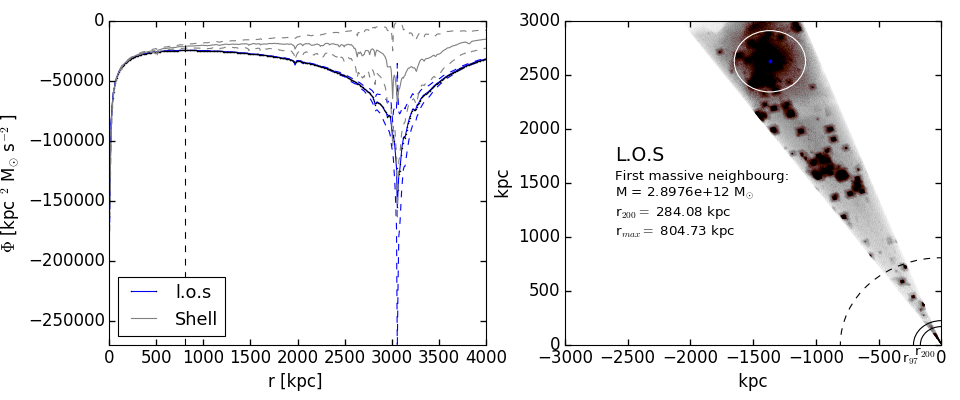

In [22]:
fig, ax = plt.subplots(1,2,figsize=[12,5])

#fig, ax[0] = plt.subplots()
ax[0].set_xlim([0,4000])
ax[0].set_ylim([-2.7e5,0])
#ax.set_ylim([pot_sph.min(),np.abs(pot_sph.min())/6.])
ax[0].set_ylabel(r'$\Phi$ [kpc $^2$ M$_{\odot}$ s$^{-2}$ ] ', fontsize=15)
#ax.set_xscale('log')
ax[0].set_xlabel(r'r [kpc] ', fontsize=15)
ax[0].plot(r_phi_los, mean_phi_los+std_phi_los, 'b--')
ax[0].plot(r_phi_los, mean_phi_los-std_phi_los, 'b--')
ax[0].plot(r_phi_los, mean_phi_los, 'bo-',markersize=0.8,label="l.o.s")
ax[0].plot(r_phi,mean_phi,color='gray',ls='-', label='Shell')
ax[0].plot(r_phi,mean_phi+std_phi,color='gray',ls='--')
ax[0].plot(r_phi,mean_phi-std_phi,color='gray',ls='--')
ax[0].axvline(x=R_MAX,color='k',linestyle='--')


ax[1].set_xlim([-3000,0])
ax[1].set_ylim([0,3000])
ax[1].set_xlabel(r' kpc ', fontsize=15)
ax[1].set_ylabel(r' kpc ', fontsize=15)
texto_neigh = "First massive neighbourg: \n"
texto_neigh += "M = {0:.4e}".format(mass_neigh)
texto_neigh += r" M$_{\odot}$"+"\n"
texto_neigh += r"r$_{200} = $ "+"{0:.2f} kpc\n".format(r200_neigh)
texto_neigh += r"r$_{max} = $ "+"{0:.2f} kpc".format(float(R_MAX))
ax[1].text(-2600,1700,"L.O.S",fontsize=17)
ax[1].text(-2600,1000,texto_neigh)
ax[1].scatter(my_cone[:,0], my_cone[:,2],c="#902b08",lw=0,s=0.01,alpha=0.5)
ax[1].scatter(myneighbourg[0],myneighbourg[2],s=20)
circle = plt.Circle(((0),(0)),myhalo.r200, color='k',lw=1, fill=False)
ax[1].add_patch( circle )
circle = plt.Circle(((0),(0)),myhalo.r97, color='k',lw=1, fill=False)
ax[1].add_patch( circle )
circle = plt.Circle(((0),(0)),R_MAX, color='k',ls='--',lw=1, fill=False)
ax[1].add_patch( circle )
ax[1].text(-myhalo.r200-50,-100,r'r$_{200}$')
ax[1].text(-myhalo.r97-90,-170,r'r$_{97}$')

circle = plt.Circle(((myneighbourg[0]),(myneighbourg[2])),r200_neigh, color='w',lw=1, fill=False)
ax[1].add_patch( circle )


legend = ax[0].legend(loc='lower left', ncol=1, shadow=False, fontsize=16)
frame = legend.get_frame()
fig.tight_layout(w_pad=0)
ax[0].tick_params(axis='both', which='major', labelsize=15, size=5,width=1.2)
ax[0].tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)
ax[1].tick_params(axis='both', which='major', labelsize=15, size=5,width=1.2)
ax[1].tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)
#fig.savefig("/home/arturo/Documents/git/LAMtoLUPM_latex/Rmax.pdf")

In [23]:
4500/166.

27.10843373493976

# vesc(r)+-dvesc at different radii + comparison with the value calculated from the potential

$$v_{esc} = \sqrt(-2\left(\phi(r) - \phi(r_{max}\right))$$

In [24]:
bin_num = 100
times = 3.
bins = np.logspace(np.log10(3*myhalo.gs.hsml.min()),np.log10((times*myhalo.r200)**2),bin_num)
pot_sph_vesc, bins_pot_vesc = np.histogram(r2[(r2<(times*myhalo.r200)**2)], bins=bins, weights=Phy[(r2<(times*myhalo.r200)**2)])


In [25]:
diference = np.abs(bins_pot-R_MAX)
good_index = np.where(diference==diference.min())[0]
rmax = R_MAX
pot_max =np.sum((pot_sph/n)[good_index])/len(good_index)


In [26]:
def vesc_from_pot(limmin, limmax):
    """
    a function calculating the vesc from potential inside interval
    """
    contidion = (r2>limmin**2)&(r2<limmax**2)
    mean = np.average(Phy[contidion])
    sigma = np.std((Phy[contidion]))
    v_esc = np.sqrt(2*np.abs(mean - pot_max))
    sig_vesc = sigma / v_esc 
    return v_esc, sig_vesc 

In [27]:
mean_phi_vesc = np.array([])
std_phi_vesc = np.array([])
r_phi_vesc = np.array([])
for i in range(len(bins_pot_vesc)-1):
    contidion = (r2>bins_pot_vesc[i])&(r2<bins_pot_vesc[i+1])
    mean_phi_vesc = np.append(mean_phi_vesc,np.average(Phy[contidion]))
    std_phi_vesc = np.append(std_phi_vesc,np.std((Phy[contidion])))
    r_phi_vesc = np.append(r_phi_vesc, (np.sqrt(bins_pot_vesc[i])+np.sqrt(bins_pot_vesc[i+1]))/2)

In [28]:
##################################
v_esc = np.sqrt(2*np.abs(mean_phi_vesc - pot_max))
sig_vesc = std_phi_vesc / v_esc 

<IPython.core.display.Javascript object>


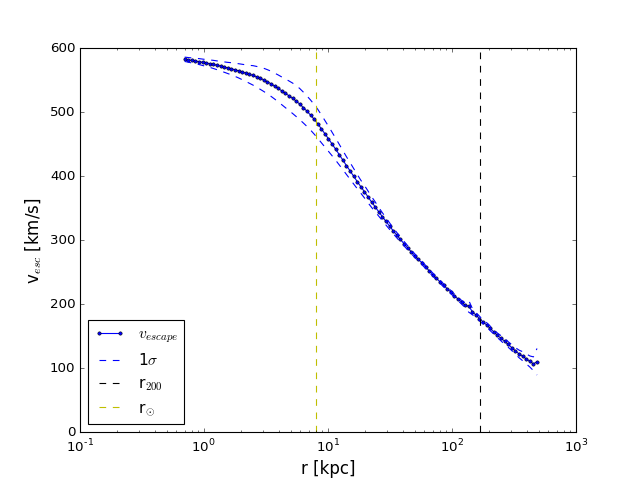

In [29]:
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.plot(r_phi_vesc, v_esc,'bo-',markersize=3,label=r"$v_{escape}$")
ax.plot(r_phi_vesc, v_esc+sig_vesc,'b--',markersize=3,label=r"1$\sigma$")
ax.plot(r_phi_vesc, v_esc-sig_vesc,'b--',markersize=3)
ax.set_xlabel("r [kpc]",fontsize=15)
ax.set_ylabel(r"v$_{esc}$ [km/s] ",fontsize=15)
ax.axvline(x=myhalo.r200,color='k',linestyle='--',label=r"r$_{200}$")
ax.axvline(x=8,color='y',linestyle='--',label=r"r$_{\odot}$")

legend = ax.legend(loc='lower left', ncol=1, shadow=False, fontsize=14)
frame = legend.get_frame()

In [33]:
limmin, limmax = 7.5, 8.5
def slice_vmax(rmin, rmax,phimin,phimax):
    in_the_shell = (myhalo.dm.r > rmin)&(myhalo.dm.r < rmax)
    in_the_slice = (myhalo.dm.phi > phimin)&(myhalo.dm.phi < phimax)
    result = myhalo.dm.v[in_the_shell&in_the_slice]
    return result.max(),len(result)
slice_vesc  = np.vectorize(slice_vmax)

def vesc_per_radius(rmin, rmax,n=20):
    if not bool(int(rmax)%50):
        print rmax
    slices = np.linspace(-np.pi,np.pi,n)
    v_maxs, N = slice_vesc(rmin,rmax,slices[:-1],slices[1:])
    return np.mean(v_maxs), np.std(v_maxs), np.sum(N)

get_vesc_from_slices = np.vectorize(vesc_per_radius)    


In [34]:
unbound_dm = dm_inside = st_inside = unbound_st = shell_vol = rho_max_bin = np.array([])
bins_lin = np.sqrt(bins_pot_vesc)
for i in range(len(bins_pot_vesc)-1):
    inside_bin_dm = np.where((myhalo.dm.r>=bins_lin[i])&(myhalo.dm.r<bins_lin[i+1]))
    inside_bin_st = np.where((myhalo.st.r>=bins_lin[i])&(myhalo.st.r<bins_lin[i+1]))
    dm_inside = np.append(dm_inside,len(myhalo.dm.mass[inside_bin_dm]))
    st_inside = np.append(st_inside,len(myhalo.st.mass[inside_bin_st]))
    unbound_dm = np.append(unbound_dm, len(np.where(myhalo.dm.v[inside_bin_dm]>v_esc[i])[0]))
    unbound_st = np.append(unbound_st,len(np.where(myhalo.st.v[inside_bin_st]>v_esc[i])[0]))
    shell_vol = np.append(shell_vol, 4.* np.pi * ((bins_lin[i+1]**3)-(bins_lin[i]**3)) / 3.)
    rho_max_bin = np.append(rho_max_bin, rho_dm[inside_bin_dm].mean())

In [35]:
slices = np.linspace(-np.pi,np.pi,20)
#slice_vesc(7.5,8.5,slices[:-1],slices[1:])

In [36]:
an_array = np.linspace(0,myhalo.r200,60)
vesc_per_radius = get_vesc_from_slices(np.sqrt(bins_pot_vesc[:-1]),np.sqrt(bins_pot_vesc[1:]))
#vesc_per_radius = get_vesc_from_slices(an_array[:-1],an_array[1:])

0.7217697265314209
0.721769726531
0.771600909994
0.824872452278
0.881821876717
0.942703105321
100.915936858
150.634402584
500.9765625


<IPython.core.display.Javascript object>


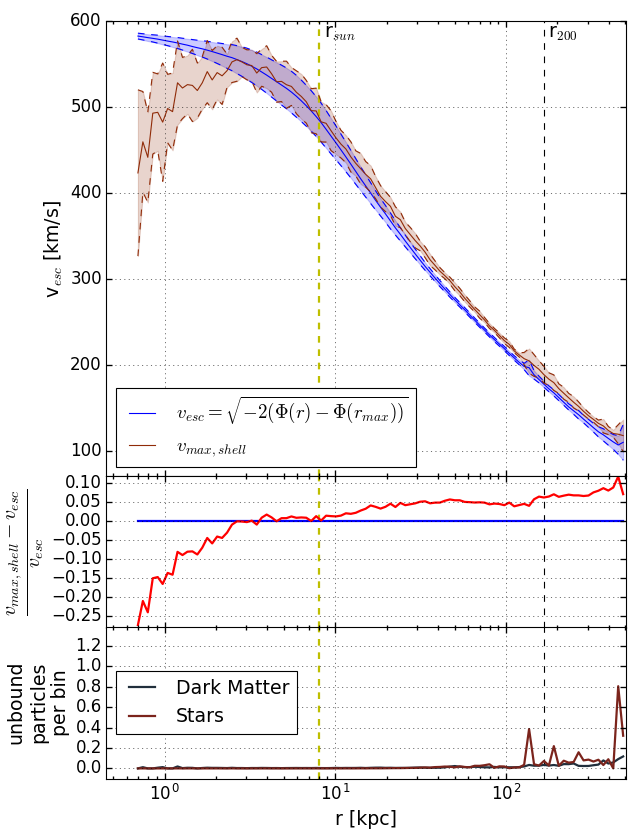

In [37]:
fig, [ax,ax1,ax2] = plt.subplots(3,1,gridspec_kw = {'height_ratios':[3., 1,1]},figsize=[8,10.5],sharex=True)
ax.set_xlim([3.*myhalo.gs.hsml.min(),3*myhalo.r200])
ax.set_ylim([70,600])
ax.set_xscale('log')
font = 17
##### from potential
ax.plot(r_phi_vesc, v_esc,'b-',markersize=3,label=r"$v_{esc}=\sqrt{-2(\Phi(r)-\Phi(r_{max}))}$")
ax.plot(r_phi_vesc, v_esc+sig_vesc,'b--',markersize=3)
#ax.plot(r_phi_vesc+2000, v_esc+sig_vesc+2000,color='gray', linestyle='--',label=r"1$\sigma$")
ax.plot(r_phi_vesc, v_esc-sig_vesc,'b--',markersize=3)
ax.fill_between(r_phi_vesc,v_esc+sig_vesc, v_esc-sig_vesc,color='b',alpha=0.2)
ax2.set_xlabel("r [kpc]",fontsize=font)
ax1.set_ylabel(r"$\frac{v_{max,shell}-v_{esc}}{v_{esc}}$",fontsize=1.5*font)
ax.set_ylabel(r"v$_{esc}$ [km/s] ",fontsize=font)
ax.axvline(x=myhalo.r200,color='k',linestyle='--')
ax1.axvline(x=myhalo.r200,color='k',linestyle='--')
ax2.axvline(x=myhalo.r200,color='k',linestyle='--')
ax.axvline(x=8,color='y',linestyle='--',linewidth=2)
ax1.axvline(x=8,color='y',linestyle='--',linewidth=2)
ax2.axvline(x=8,color='y',linestyle='--',linewidth=2)
rr = (an_array[:-1]+an_array[1:])/2
##### from shell
ax.plot(r_phi_vesc,vesc_per_radius[0],color="#902b08",linestyle="-",label=r"$v_{max,shell}$")
ax.plot(r_phi_vesc,vesc_per_radius[0]+vesc_per_radius[1],color="#902b08",linestyle="--")
ax.plot(r_phi_vesc,vesc_per_radius[0]-vesc_per_radius[1],color="#902b08",linestyle="--")
ax.fill_between(r_phi_vesc,vesc_per_radius[0]+vesc_per_radius[1],vesc_per_radius[0]-vesc_per_radius[1],color="#902b08",alpha=0.2)
#,yerr=vesc_per_radius[1], xerr=(an_array[1:]-an_array[:-1])/2,
######### second panel 
ax1.set_ylim([-0.28,0.12])
ax1.plot(r_phi_vesc,[0 for i in r_phi_vesc],color='b',lw=2)
ax1.plot(r_phi_vesc,(vesc_per_radius[0]-v_esc)/v_esc,'r-',lw=2,label=r"$v_{esc}$ from mass")
ax.text(myhalo.r200+10,580,r"r$_{200}$",fontsize=font)
ax.text(8.6,580,r"r$_{sun}$",fontsize=font)
legend = ax.legend(loc='lower left', ncol=1, shadow=False, fontsize=font)
frame = legend.get_frame()
fig.tight_layout(h_pad=-0.90)



ax2.set_ylim([-0.1,1.39])
ax2.set_xscale('log')
ax2.set_ylabel('Franction of\nunbound\nparticles\nper bin',fontsize=font)
ax2.plot(r_phi_vesc,unbound_dm / dm_inside,color='#212f3c',ls='-',lw=2,label="Dark Matter")
ax2.plot(r_phi_vesc,unbound_st / st_inside,color='#7b241c',ls='-',lw=2,label="Stars")

legend = ax2.legend(loc='center left', ncol=1, shadow=False, fontsize=font)
frame = legend.get_frame()
ax.grid()
ax1.grid()
ax2.grid()


ax.tick_params(axis='both', which='major', labelsize=15, size=5,width=1.2)
ax.tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)
ax1.tick_params(axis='both', which='major', labelsize=15, size=5,width=1.2)
ax1.tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)
ax2.tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)
ax2.tick_params(axis='both', which='major', labelsize=15, size=5,width=1.2)

#plt.savefig("/home/arturo/Documents/git/LAMtoLUPM_latex/v_esc.png",dpi=300)

In [38]:
get_mat =  np.vectorize(nbe.m_matrix_for_r)

In [ ]:
#r = np.logspace(np.log10(myhalo.gs.hsml.min()),np.log10(2*myhalo.r200),15)
r = np.linspace(myhalo.gs.hsml.min(),2*myhalo.r200,300)
M_dm = np.array([nbe.m_matrix_for_r(myhalo,'halo',i) for i in r])
M_st = np.array([nbe.m_matrix_for_r(myhalo,'stars',i) for i in r])
a_dm, b_dm, c_dm = np.sqrt(M_dm[:,0,0]), np.sqrt(M_dm[:,1,1]), np.sqrt(M_dm[:,2,2])
a_st, b_st, c_st = np.sqrt(M_st[:,0,0]), np.sqrt(M_st[:,1,1]), np.sqrt(M_st[:,2,2])
S_dm = c_dm/a_dm
T_dm = ((a_dm**2) - (b_dm**2))/((a_dm**2) -(c_dm**2)) 
S_st = c_st/a_st
T_st = ((a_st**2) - (b_st**2))/((a_st**2) -(c_st**2)) 

<IPython.core.display.Javascript object>


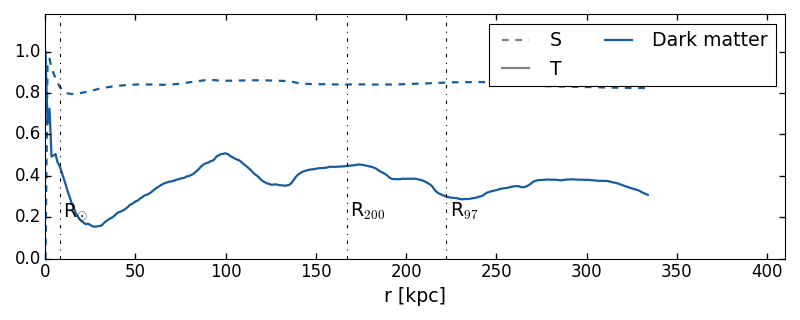

In [40]:
fig, ax = plt.subplots(figsize=[10,4])
#ax.set_xlim(4,250)
ax.set_ylim(0,1.18)
ax.set_xlim(0,410)
ax.set_xlabel('r [kpc]',fontsize=font)
ax.plot([4,5],[1e3,2e3],color='gray',linestyle='--',lw=2,label="S")
ax.plot([4,5],[1e3,2e3],color='gray',linestyle='-',lw=2,label="T")
ax.plot(r,T_dm,'-',color='#155c9e',lw=2,label="Dark matter")
ax.plot(r,S_dm,'--',color='#155c9e',lw=2)
#ax.plot(r,T_st,'-',color='#a91e4f',lw=2,label='stars')
#ax.plot(r,np.sqrt(S_st),'--',color='#a91e4f',lw=2)
ax.axvline(x=myhalo.r200,color='k',linestyle='-.')
ax.text(myhalo.r200+2,0.2,r"R$_{200}$",fontsize=font)
ax.axvline(x=myhalo.r97,color='k',linestyle='-.')
ax.text(myhalo.r97+2,0.2,r"R$_{97}$",fontsize=font)
ax.axvline(x=8,color='k',linestyle='-.')
ax.text(10,0.2,r"R$_{\odot}$",fontsize=font)


legend = ax.legend(loc='upper right', ncol=2, shadow=False, fontsize=font)
frame = legend.get_frame()
ax.tick_params(axis='both', which='major', labelsize=15, size=5,width=1.2)
ax.tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)
fig.tight_layout()

#  histograms of f(v) at different radii with chi2 (Eddington vs. Maxwellian) - already done, except for the Maxwellian case. 

In [37]:
def maxw(v,sigma):
    N = np.sqrt(32 * np.pi) * v**2 / sigma**3
    return N * np.exp(- v**2 / 2. / sigma**2)

get_maxw = np.vectorize(maxw)

In [38]:
def eddingtong_from_file(path):
    v = np.array([])
    fv = np.array([])
    files = open(path)
    for line in files:
        row = line.split(' ')
        if np.isnan(float(row[3][:-1])):
            continue
        v = np.append(v,float(row[0]))
        fv = np.append(fv,float(row[3][:-1]))
    return v,fv

def fdv_plot_chi2_max_edd(ax, path, limmin, limmax,save=False,outname="/home/arturo/Pictures/ploto",width=None):
    # get eddington fdv from file
    v, fv = eddingtong_from_file(path)
    # interpolation of eddington points
    f = interp1d(v,fv)
    # get data points from simulations errors included
    # particles in the shell between limmin and limmax
    shell_wc = (myhalo.dm.r>limmin)&(myhalo.dm.r<limmax)
    if width == None:
        width = limmin /6.
    disc = (np.abs(myhalo.dm.pos3d[:,2])<width)
    local_v_wc = myhalo.dm.v[shell_wc]
    v_disc_in_the_shell = myhalo.dm.v[shell_wc&disc]
    Ntot=len(local_v_wc)
    # speed distribution in the shell
    bins = np.linspace(0,local_v_wc.max(),30)
    hist_wc, bins_wc = np.histogram(myhalo.dm.v[shell_wc],bins=bins,normed=True)
    x = (bins_wc[1:]+bins_wc[:-1])/2
    # considering informations from theory inside the bins
    fv_the = np.array([])
    N = np.array([])
    test = np.array([])
    means = np.array([])
    N_disc = np.array([])
    for i in range(len(bins_wc)-1):
        try:
            fv_the = np.append(fv_the, quad(f,bins_wc[i],bins_wc[i+1])[0] / (bins_wc[i+1] - bins_wc[i]))
            test = np.append(test,(bins_wc[i+1]+ bins_wc[i])/2)
            pop = local_v_wc[(local_v_wc>bins_wc[i])&(local_v_wc<=bins_wc[i+1])]
            disc_in_the_bin = v_disc_in_the_shell[(v_disc_in_the_shell>bins_wc[i])&(v_disc_in_the_shell<=bins_wc[i+1])]
            means, N = np.append(means,np.average(pop)), np.append(N,len(pop))
            N_disc = np.append(N_disc,len(disc_in_the_bin))
        except:
            test = np.append(test,(bins_wc[i+1]+ bins_wc[i])/2)
            fv_the = np.append(fv_the,0.0)
            pop = local_v_wc[(local_v_wc>bins_wc[i])&(local_v_wc<=bins_wc[i+1])]
            disc_in_the_bin = v_disc_in_the_shell[(v_disc_in_the_shell>bins_wc[i])&(v_disc_in_the_shell<=bins_wc[i+1])]
            means, N = np.append(means,np.average(pop)), np.append(N,len(pop))
            N_disc = np.append(N_disc,len(disc_in_the_bin))

    dof = len(test)  
    # normalizations factor for data histogram
    Ntot = np.trapz(N,x=means)
    ## MAXWELLIAN Fdv
    # circular velocity
    enclosed_m = (np.sum(mass[np.where(r2<limmin**2)])+ np.sum(mass[np.where(r2<limmax**2)]))/2.
    vc = np.sqrt(myhalo.p.G * enclosed_m / ((limmin + limmax) /2 )) * myhalo.p.kpctokm
    # for gas
    vc_gas = np.mean(myhalo.gs.vphi[(myhalo.gs.R>limmin)&(myhalo.gs.R<limmax)&(np.abs(myhalo.gs.pos3d[:,2])<2.)])
    std_vc_gas = np.std(myhalo.gs.vphi[(myhalo.gs.R>limmin)&(myhalo.gs.R<limmax)&(np.abs(myhalo.gs.pos3d[:,2])<2.)])
    #for stars
    vc_stars = np.nanmean(myhalo.st.vphi[(myhalo.st.R>limmin)&(myhalo.st.R<limmax)&(np.abs(myhalo.st.pos3d[:,2])<2.)])
    print np.nanmean(myhalo.st.vphi[(myhalo.st.r<limmin)&(myhalo.st.r<limmax)])
    std_vc_stars = np.nanstd(myhalo.st.vphi[(myhalo.st.r>limmin)&(myhalo.st.r<limmax)])    
    leno = len(myhalo.st.vphi[(myhalo.st.r<limmin)&(myhalo.st.r<limmax)])
    # this sigma is a parameter in the fdv not an error of any kind
    #sigma_8  = vc / np.sqrt(2.)
    #sigma_8  = vc_gas / np.sqrt(2.)
    sigma_8  = vc_stars / np.sqrt(2.)
    print "sigma = {0:0.1f}, vc = {1:.1f} km/s".format(sigma_8,vc)
    maxwellian = get_maxw(test,sigma_8)
    # normalizarion factor
    N0 = np.trapz(maxwellian, x=test)
    maxwellian /= N0
    ## CHI2 s 
    #error in data
    sigma = np.sqrt(N) / Ntot
    sigma_disc = np.sqrt(N_disc) / Ntot
    # eddington
    chi2 = np.sum(((N/Ntot) - fv_the)**2 / sigma**2)
    # maxwellian
    chi2_max = np.sum(((N/Ntot) - maxwellian)**2 / sigma**2)
    # v escape from potential
    v_esc , sig_vesc = vesc_from_pot(limmin,limmax)
    # plotting
    ax.set_xlim([0,1.2*v_esc])
    ax.set_ylim([0,1.3*fv_the.max()])
    ax.plot(means,fv_the,'k-',label="eddington")#,yerr=means/np.sqrt(N),xerr=sigma_x)
    ax.errorbar(test,N/Ntot,yerr=np.sqrt(N)/Ntot,xerr=((bins[1:]-bins[:-1])/2.)[:dof],c='g',lw=1.5, label="data")
    ax.errorbar(test,N_disc/Ntot,yerr=np.sqrt(N_disc)/Ntot,xerr=((bins[1:]-bins[:-1])/2.)[:dof],c='gray',
                lw=1.2, ls='None', label=r"in disc of $\Delta$z "+"= {0} kpc".format(2*width))
    ax.set_xlabel(r"$\vec{v}$ [km/s]",fontsize=16)
    ax.set_ylabel(r"$f(v)_{normalized} $ ",fontsize=18)
    ax.axvline(x=v_esc,color='k',linestyle='--')
    ax.axvspan(v_esc-sig_vesc, v_esc+sig_vesc, alpha=0.5, color='red',label=r"$v_{esc} \pm 1\sigma$ ")
    texto_max = "Maxwellian\n"
    texto_max += r"$\chi_{red}^2 = $"
    texto_max += "{0:.2f}".format(chi2_max/dof)
    texto_edd = "Eddington\n"
    texto_edd += r"$\chi_{red}^2 = $"
    texto_edd += "{0:.2f}".format(chi2/dof)
    #texto_vc = r"$v_c = $"
    #texto_vc += " {0:.2f} km/s".format(vc)
    #texto_vc += "\n"
    #texto_vc = r"$v_c ^{gas} =$ "
    #texto_vc += "{0:.2f}".format(vc_gas)
    #texto_vc += r" $\pm$ "
    #texto_vc  +="{0:.2f}".format(std_vc_gas)
    texto_vc = r"$v_c ^{stars} =$ "
    texto_vc += "{0:.2f}".format(vc_stars,leno)
    texto_vc += "\n"
    texto_vc += "dof = {0}".format(dof)
    
    fig.text(0.15,0.79,texto_max,fontsize=16,color='r')
    fig.text(0.15,0.71,texto_edd,fontsize=16,color='k')
    fig.text(0.15,0.60,texto_vc,fontsize=16,color='k')

    ax.set_title(str(limmin)+" kpc < r < "+str(limmax)+" kpc ", fontsize=18)
    max_v = np.linspace(0,1.5*test.max(),50)
    ax.plot(max_v,get_maxw(max_v,sigma_8)/N0,'r-',label="maxwellian")
    legend = ax.legend(loc='upper right', ncol=1, shadow=False, fontsize=14)
    frame = legend.get_frame()
    if (save):
        plt.savefig(outname+".pdf",dpi=300)

In [39]:
"""
fig, ax = plt.subplots(figsize=[9,8])
path = '/home/arturo/Downloads/fv_df0_model13_bar3_r3_rmax500_div0 (1).dat'
fdv_plot_chi2_max_edd(ax, path, 2.5, 3.5,width=0.8,save=True,
                      outname='/home/arturo/Documents/LAM/LAM2LUPM/report07-17/HaloB/fdv_MAX_EDD_3kpc_vcstars')
fig, ax = plt.subplots(figsize=[9,8])
path = '/home/arturo/Downloads/fv_df0_model13_bar3_r8_rmax500_div0 (1).dat'
fdv_plot_chi2_max_edd(ax, path, 7.5, 8.5,save=True,
                      outname='/home/arturo/Documents/LAM/LAM2LUPM/report07-17/HaloB/fdv_MAX_EDD_8kpc_vcstars')
fig, ax = plt.subplots(figsize=[9,8])
path = '/home/arturo/Downloads/fv_df0_model13_bar3_r20_rmax500_div0 (1).dat'
fdv_plot_chi2_max_edd(ax, path, 19.5, 20.5,save=True,
                      outname='/home/arturo/Documents/LAM/LAM2LUPM/report07-17/HaloB/fdv_MAX_EDD_20kpc_vcstars')
fig, ax = plt.subplots(figsize=[9,8])
path = '/home/arturo/Downloads/fv_df0_model13_bar3_r50_rmax500_div0 (1).dat'
fdv_plot_chi2_max_edd(ax, path, 45, 55,save=True,
                      outname='/home/arturo/Documents/LAM/LAM2LUPM/report07-17/HaloB/fdv_MAX_EDD_50kpc_vcstars')
"""                


"\nfig, ax = plt.subplots(figsize=[9,8])\npath = '/home/arturo/Downloads/fv_df0_model13_bar3_r3_rmax500_div0 (1).dat'\nfdv_plot_chi2_max_edd(ax, path, 2.5, 3.5,width=0.8,save=True,\n                      outname='/home/arturo/Documents/LAM/LAM2LUPM/report07-17/HaloB/fdv_MAX_EDD_3kpc_vcstars')\nfig, ax = plt.subplots(figsize=[9,8])\npath = '/home/arturo/Downloads/fv_df0_model13_bar3_r8_rmax500_div0 (1).dat'\nfdv_plot_chi2_max_edd(ax, path, 7.5, 8.5,save=True,\n                      outname='/home/arturo/Documents/LAM/LAM2LUPM/report07-17/HaloB/fdv_MAX_EDD_8kpc_vcstars')\nfig, ax = plt.subplots(figsize=[9,8])\npath = '/home/arturo/Downloads/fv_df0_model13_bar3_r20_rmax500_div0 (1).dat'\nfdv_plot_chi2_max_edd(ax, path, 19.5, 20.5,save=True,\n                      outname='/home/arturo/Documents/LAM/LAM2LUPM/report07-17/HaloB/fdv_MAX_EDD_20kpc_vcstars')\nfig, ax = plt.subplots(figsize=[9,8])\npath = '/home/arturo/Downloads/fv_df0_model13_bar3_r50_rmax500_div0 (1).dat'\nfdv_plot_chi2_max_ed

In [10]:
def circular_speed(r,comp="all"):
    if comp=='all': 
        m = mass
        radii = np.sqrt(r2)
    elif comp=="dm":
        m = myhalo.dm.mass
        radii = myhalo.dm.r
    elif comp=="st":
        m = myhalo.st.mass
        radii = myhalo.st.r
    elif comp=="gs":
        m = myhalo.gs.mass
        radii = myhalo.gs.r
    else:
        sys.exit("no valid component")
    enclosed_m = np.sum(m[np.where(radii<r)])
    return np.sqrt(myhalo.p.G * enclosed_m / r) * myhalo.p.kpctokm

get_vc= np.vectorize(circular_speed)
r = np.linspace(0,35,50)
vc_all = get_vc(r,comp='all')
vc_dm = get_vc(r,comp='dm')
vc_st = get_vc(r,comp='st')
vc_gs = get_vc(r,comp='gs')

In [14]:
vc_stars_vphi = gas_mass_r = stars_mass_r = std_stars_vphi = vc_gas_vphi = std_gas_vphi = np.array([])
for i in range(len(r)-1):
    stars_condition = (myhalo.st.R>r[i])&(myhalo.st.R<r[i+1])&(np.abs(myhalo.st.pos3d[:,2])<0.5)
    gas_condition = (myhalo.gs.R>r[i])&(myhalo.gs.R<r[i+1])&(np.abs(myhalo.gs.pos3d[:,2])<0.5)
    # for gas
    vc_gas_vphi = np.append(vc_gas_vphi, np.average(myhalo.gs.vphi[gas_condition]))
    std_gas_vphi = np.append(std_gas_vphi, np.std(myhalo.gs.vphi[gas_condition]))
    gas_mass_r= np.append(gas_mass_r, np.sum(myhalo.gs.mass[gas_condition]))
    #for stars
    vc_stars_vphi = np.append(vc_stars_vphi, np.nanmean(myhalo.st.vphi[stars_condition]))
    std_stars_vphi = np.append(std_stars_vphi, np.nanstd(myhalo.st.vphi[stars_condition]))
    stars_mass_r= np.append(stars_mass_r, np.sum(myhalo.st.mass[stars_condition]))
    
r_arrays = (r[1:] + r[:-1]) / 2.

<IPython.core.display.Javascript object>


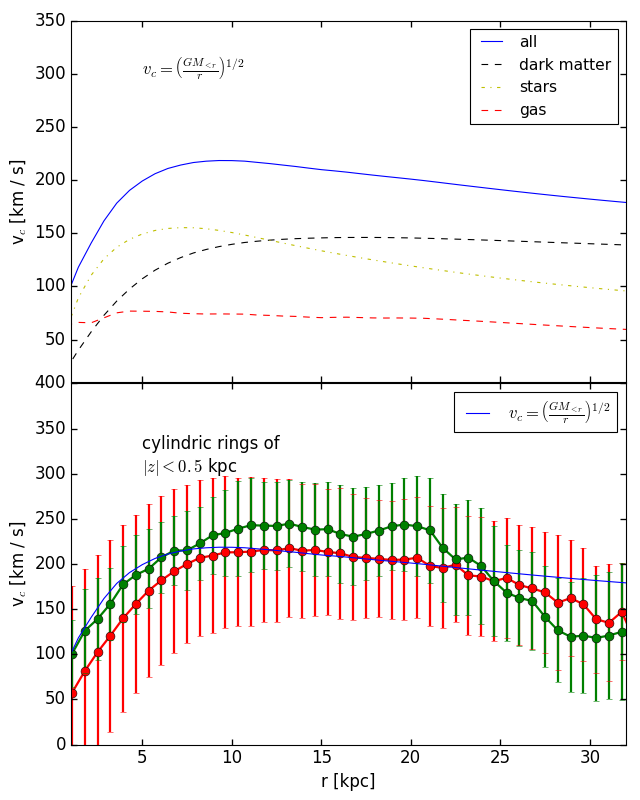

In [28]:
fig, [ax,ax1] = plt.subplots(2,1,figsize=[8,10])
ax.set_xlim(1,32)
ax.set_ylim(10,350)
#ax.set_title("Rotation curve\nHalo B",fontsize=18)
ax.plot(r, vc_all,'b-',label='all')
ax.plot(r, vc_dm, 'k--',label='dark matter')
ax.plot(r, vc_st, 'y-.',label='stars')
ax.plot(r, vc_gs ,'r--',label='gas')
texto  = r"$v_c = \left(\frac{G M_{<r}}{r}\right)^{1/2}$"
ax.text(5,300,texto,fontsize=15)
#ax.set_xlabel("r [kpc]",fontsize=15)
ax.set_ylabel(r"v$_{c}$ [km / s]",fontsize=15)
legend = ax.legend(loc='upper right', ncol=1, shadow=False, fontsize=14)
frame = legend.get_frame()

ax1.set_ylim(0,400)
ax1.set_xlim(1,32)
ax1.errorbar(r_arrays,vc_stars_vphi,yerr=std_stars_vphi,color='r',marker='o',markersize=8,lw=2)
#ax1.plot(r_arrays,vc_stars_vphi-std_stars_vphi,'r--')
#ax1.fill_between(r_arrays,vc_stars_vphi+std_stars_vphi, vc_stars_vphi-std_stars_vphi,color='r',alpha=0.2)
#ax1.plot(r_arrays,vc_stars_vphi,'ro-',markersize=4,markeredgewidth=0,label=r"$\left<v_{\phi}\right>_{stars} \pm 1 \sigma$ ")
#ax1.plot(r_arrays,vc_gas_vphi+std_gas_vphi,'g--')
ax1.errorbar(r_arrays,vc_gas_vphi,yerr=std_gas_vphi,color='g',marker='o',markersize=8,lw=2)
#ax1.fill_between(r_arrays,vc_gas_vphi+std_gas_vphi, vc_gas_vphi-std_gas_vphi,color='g',alpha=0.2)
texto_dos = "cylindric rings of\n"
texto_dos += r"$|z| <  0.5$ kpc"
ax1.text(5,300,texto_dos,fontsize=15)

#ax1.plot(r_arrays,vc_gas_vphi,'go-',markersize=4,markeredgewidth=0,label=r"$\left<v_{\phi}\right>_{gas}\pm 1 \sigma$")

ax1.plot(r,vc_all,'b-',label=r"$v_c = \left(\frac{G M_{<r}}{r}\right)^{1/2}$")

ax1.set_xlabel("r [kpc]",fontsize=15)
ax1.set_ylabel(r"v$_{c}$ [km / s]",fontsize=15)
legend = ax1.legend(loc='upper right', ncol=1, shadow=False, fontsize=15)
frame = legend.get_frame()
fig.tight_layout(h_pad=-1.7)
ax.tick_params(axis='both', which='major', labelsize=15, size=5,width=1.2)
ax.tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)
ax1.tick_params(axis='both', which='major', labelsize=15, size=5,width=1.2)
ax1.tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)




<IPython.core.display.Javascript object>


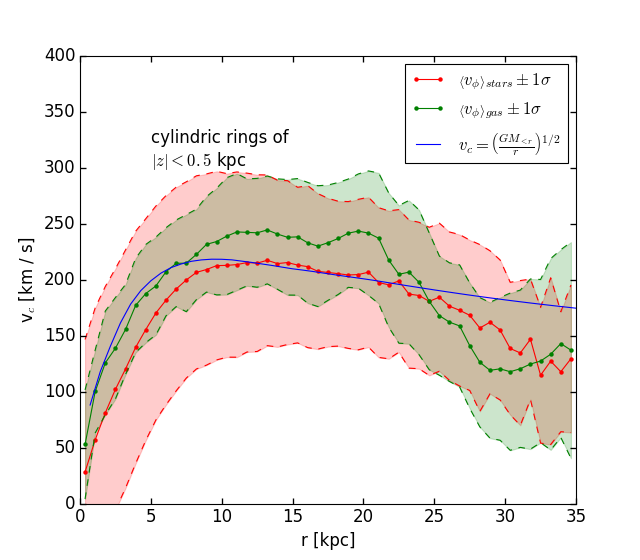

In [43]:
fig, ax1 = plt.subplots(figsize=[8,7])


ax1.set_ylim(0,400)
ax1.plot(r_arrays,vc_stars_vphi+std_stars_vphi,'r--')
ax1.plot(r_arrays,vc_stars_vphi-std_stars_vphi,'r--')
ax1.fill_between(r_arrays,vc_stars_vphi+std_stars_vphi, vc_stars_vphi-std_stars_vphi,color='r',alpha=0.2)
ax1.plot(r_arrays,vc_stars_vphi,'ro-',markersize=4,markeredgewidth=0,label=r"$\left<v_{\phi}\right>_{stars} \pm 1 \sigma$ ")
ax1.plot(r_arrays,vc_gas_vphi+std_gas_vphi,'g--')
ax1.plot(r_arrays,vc_gas_vphi-std_gas_vphi,'g--')
ax1.fill_between(r_arrays,vc_gas_vphi+std_gas_vphi, vc_gas_vphi-std_gas_vphi,color='g',alpha=0.2)
texto_dos = "cylindric rings of\n"
texto_dos += r"$|z| <  0.5$ kpc"
ax1.text(5,300,texto_dos,fontsize=15)

ax1.plot(r_arrays,vc_gas_vphi,'go-',markersize=4,markeredgewidth=0,label=r"$\left<v_{\phi}\right>_{gas}\pm 1 \sigma$")

ax1.plot(r,vc_all,'b-',label=r"$v_c = \left(\frac{G M_{<r}}{r}\right)^{1/2}$")

ax1.set_xlabel("r [kpc]",fontsize=15)
ax1.set_ylabel(r"v$_{c}$ [km / s]",fontsize=15)
legend = ax1.legend(loc='upper right', ncol=1, shadow=False, fontsize=15)
frame = legend.get_frame()
ax1.tick_params(axis='both', which='major', labelsize=15, size=5,width=1.2)
ax1.tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)


In [45]:
myhalo.gs.vtheta

array([-20544.47020868, -13935.22909475, -17211.67847609, ...,
        21498.67289397,  21505.44275181,  21442.13454062])

In [44]:
myhalo.gs.vphi

array([ -7.53002096,  -5.67208329,  -6.55299355, ..., -58.87152466,
       -58.56974993, -58.62606322])

In [46]:
myhalo.dm.phi = Phy[:len(myhalo.dm.mass)]
myhalo.gs.phi = Phy[len(myhalo.dm.mass):len(myhalo.gs.mass)]
myhalo.st.phi = Phy[len(myhalo.dm.mass)+len(myhalo.gs.mass):]


# $\mathcal{E}$ for DM particles inside R$_{200}$

In [47]:
print 2**5

32


In [48]:
inside = np.where(myhalo.dm.r < myhalo.r200)
epsilon = -myhalo.dm.phi[inside] - 0.5*(myhalo.dm.v[inside]**2)
e_max = epsilon[np.where(myhalo.dm.r[inside]==myhalo.dm.r[inside].min())]
print e_max
binnum = 2**8 # 128
bins = np.linspace(0,e_max,binnum)
hist_ep, bins = np.histogram(epsilon,bins=bins,normed=1)
bins_c = (bins[:-1]+bins[1:])/2.
bins_width = (bins[1:]-bins[:-1])


[159021.93329624]


<IPython.core.display.Javascript object>


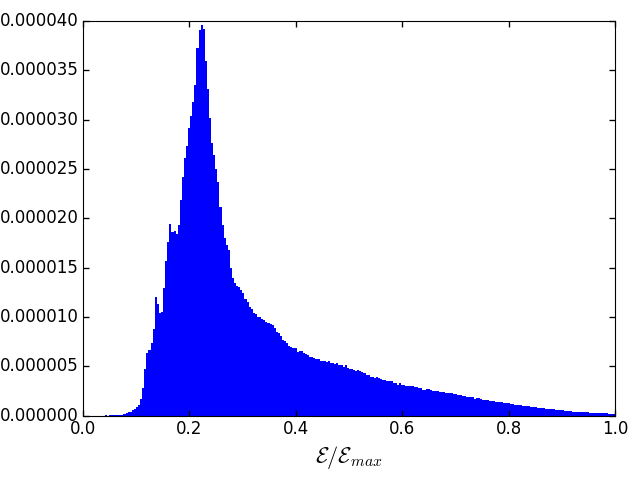

In [49]:
fig,ax = plt.subplots()
ax.set_xlim([0,1])
#ax.set_xlabel('r[kpc]',fontsize=18)
ax.set_xlabel(r'$\mathcal{E}/\mathcal{E}_{max}$',fontsize=20)
ax.bar(bins_c/e_max,hist_ep,width=bins_width/e_max,lw=0)
fig.tight_layout()
ax.tick_params(axis='both', which='major', labelsize=15, size=5,width=1.2)
ax.tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)
plt.savefig("/home/arturo/Documents/git/LAMtoLUPM_latex/f_E.pdf")

# $\frac{\vec{L}}{m}$ for particles inside R$_{200}$

In [50]:
L = np.sqrt(myhalo.dm.vphi**2 + myhalo.dm.vtheta**2)*myhalo.dm.r
L = L[inside]
#bins = np.logspace(np.log10(myhalo.gs.hsml.min()),np.log10(myhalo.r200),512)
bins = np.linspace(0,L.max(),binnum)
hist_L, Lbins = np.histogram(L,bins=bins,normed=1)
Lbins_c = (Lbins[:-1]+Lbins[1:])/2.
Lbins_width = (Lbins[1:]-Lbins[:-1])


<IPython.core.display.Javascript object>


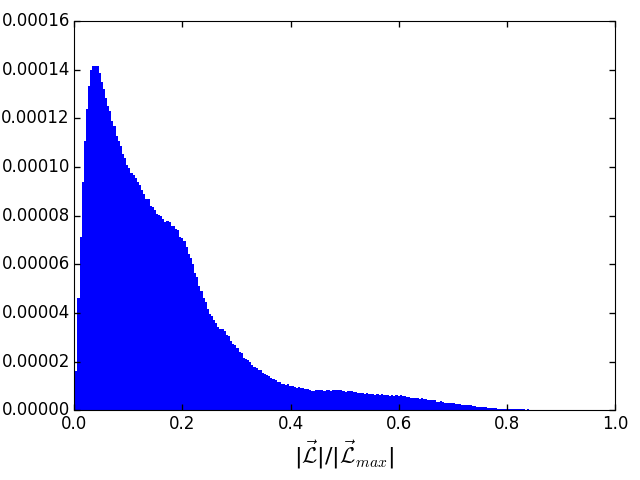

In [51]:
fig,ax = plt.subplots()
ax.set_xlim([0,1])
#ax.set_xlabel('r[kpc]',fontsize=18)
ax.set_xlabel(r'|$\vec{\mathcal{L}}$|/|$\vec{\mathcal{L}}_{max}$|',fontsize=20)
#ax.axvline(x=1,color="k",linestyle='--')
ax.bar(Lbins_c/L.max(),hist_L,width=Lbins_width/L.max(),lw=0)
fig.tight_layout()
ax.tick_params(axis='both', which='major', labelsize=15, size=5,width=1.2)
ax.tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)
plt.savefig("/home/arturo/Documents/git/LAMtoLUPM_latex/f_L.png",dpi=300)

# Correlation(?)


<IPython.core.display.Javascript object>


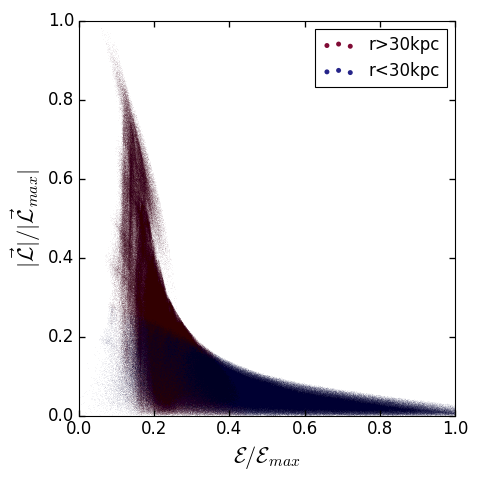

In [52]:
fig, ax = plt.subplots(figsize=[6,6])
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_xlabel(r"$\mathcal{E}/\mathcal{E}_{max}$",fontsize=20)
ax.set_ylabel(r"$|\vec{\mathcal{L}}|/|\vec{\mathcal{L}}_{max}|$",fontsize=20)

out = [np.where(myhalo.dm.r[inside]>30)]
ax.scatter(epsilon[out] / e_max, L[out]/L.max(),s=0.2,alpha=0.1,lw=0,c='#800b35')
ax.scatter(100,100,s=20,lw=0,c='#800b35',label='r>30kpc')

indisc = [np.where(myhalo.dm.r[inside]<30)]
ax.scatter(epsilon[indisc] / e_max, L[indisc]/L.max(),s=0.2,alpha=0.1,lw=0,c='#252489')
ax.scatter(100,100,s=20,lw=0,c='#252489',label='r<30kpc')

legend = ax.legend(loc='upper right', ncol=1, shadow=False, fontsize=15)
frame = legend.get_frame()
fig.tight_layout()
ax.tick_params(axis='both', which='major', labelsize=15, size=5,width=1.2)
ax.tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)
plt.savefig("/home/arturo/Documents/git/LAMtoLUPM_latex/corrLE.png",dpi=300)

In [54]:
x_edges = np.linspace(0,1,binnum)
y_edges = np.linspace(0,1,binnum)

hist2d,xbins2d,ybins2d = np.histogram2d(epsilon/e_max,L/L.max(),bins=[x_edges,y_edges])

<IPython.core.display.Javascript object>


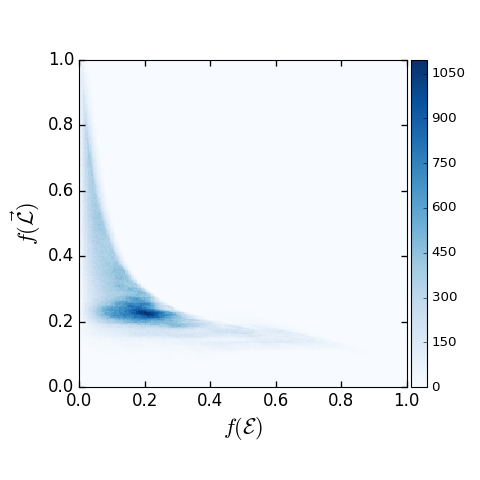

In [55]:
fig, ax = plt.subplots(figsize=[6,6])
ax.set_xlabel(r"$f(\mathcal{E})$",fontsize=20)
ax.set_ylabel(r"$f(\vec{\mathcal{L}})$",fontsize=20)

mass_1 = ax.imshow(hist2d, interpolation='nearest', origin='low',cmap="Blues",
                       extent=[xbins2d[0], xbins2d[-1], ybins2d[0], ybins2d[-1]],
                  )
divider = make_axes_locatable(ax)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mass_1,cax=cax)

fig.tight_layout()
ax.tick_params(axis='both', which='major', labelsize=15, size=5,width=1.2)
ax.tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)
plt.savefig("/home/arturo/Documents/git/LAMtoLUPM_latex/corrfLfE.png",dpi=300)

<IPython.core.display.Javascript object>


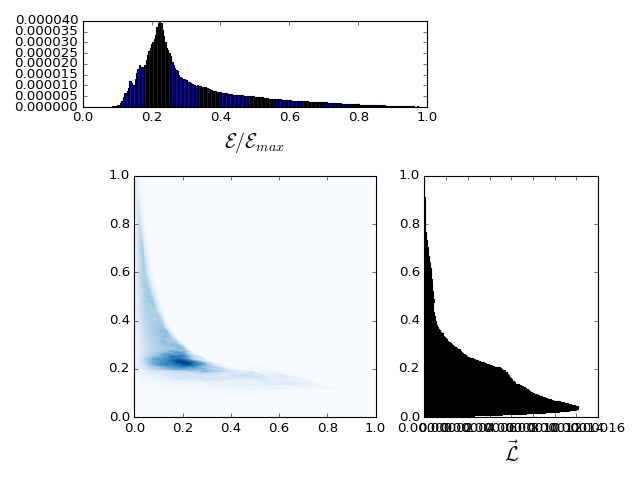

In [56]:
fig = plt.figure()

ax1 = plt.subplot2grid((3, 3), (0, 0),colspan=2)
ax3 = plt.subplot2grid((3, 3), (1, 0), colspan=2, rowspan=2)
ax4 = plt.subplot2grid((3, 3), (1, 2), rowspan=2)
ax1.set_xlim([0,1])
ax4.set_ylim([0,1])

ax1.set_xlabel(r'$\mathcal{E}/\mathcal{E}_{max}$',fontsize=18)
ax1.bar(bins_c/e_max,hist_ep,width=bins_width/e_max)

mass_1 = ax3.imshow(hist2d, interpolation='nearest', origin='low',cmap="Blues",
                       extent=[xbins2d[0], xbins2d[-1], ybins2d[0], ybins2d[-1]],
                  )
divider = make_axes_locatable(ax3)

ax4.set_xlabel(r'$\vec{\mathcal{L}}$',fontsize=18)
#ax.axvline(x=1,color="k",linestyle='--')
ax4.barh(Lbins_c/L.max(),hist_L,height=Lbins_width/L.max())
fig.tight_layout(w_pad=-1)

# Moments of f(v)

### First moment  

In [57]:

bis = np.logspace(np.log10(myhalo.gs.hsml.min()),np.log(myhalo.r200),)

# Energy Jacobian K($\mathcal{E}$)

In [58]:
r_sorted_dm = np.argsort(myhalo.dm.r)
r_K_DM = myhalo.dm.r[r_sorted_dm]
pot_K_DM = myhalo.dm.phi[r_sorted_dm]
pot_of_r = interp1d(r_K_DM,pot_K_DM)

In [60]:
#fig, ax = plt.subplots()
#ax.set_yscale('log')
def K_of_E(E,rmin,rmax):
    """
    Energy Jacobian 
    rmin and rmax should be in kpc 
    and E in km^2 Msun s^-2
    retunrs:
    integral and error
    integral = (4\pi)^2 \int_{rmin}^{rmax} r^2 \sqrt(2(|\Phi|-\mathcal{E})) 
    """
    def integrand(r):
        #if (np.abs(pot_of_r(r))>E):
        return (4.* np.pi * r)**2 * np.sqrt(2*(np.abs(pot_of_r(r)) - E))
    r_array = np.linspace(rmin,rmax,1e6)
    inte_array= integrand(r_array)
#    print inte_array
    inte_array = np.nan_to_num(inte_array)
#    ax.plot(r_array,-pot_of_r(r_array))
    return simps(inte_array,r_array)
    
"""
E = np.linspace(0.,e_max,50)

r = 10**np.linspace(np.log10(1.),np.log10(myhalo.r200),100)
r_E = np.reshape(np.repeat(r,len(E)),(len(r),len(E)))
print integrand(r_E)
#integral = simps(integrand(r_E),r_E,axis=0)
"""
K_of_E_vec = np.vectorize(K_of_E)
E = np.linspace(-1.1,e_max,100)
KE = K_of_E_vec(E,0.3,4*myhalo.r200)


<IPython.core.display.Javascript object>


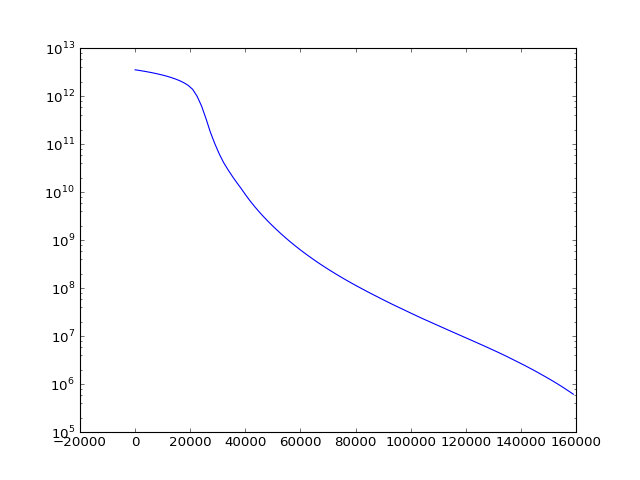

In [61]:
fig, ax = plt.subplots()
ax.set_yscale('log')
fK_of_E_ = interp1d(E,KE)
ax.plot(E,KE)

<IPython.core.display.Javascript object>


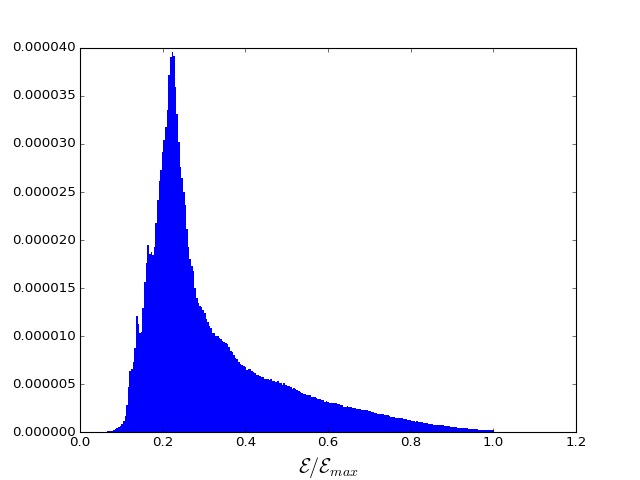

<Container object of 255 artists>

In [62]:
fig,ax = plt.subplots()
#ax.set_xlim([0,1])
#ax.set_xlabel('r[kpc]',fontsize=18)
ax.set_xlabel(r'$\mathcal{E}/\mathcal{E}_{max}$',fontsize=18)
ax.bar(bins_c/e_max,hist_ep,width=bins_width/e_max,lw=0)

In [63]:
k_corr = fK_of_E_(bins_c)

<IPython.core.display.Javascript object>


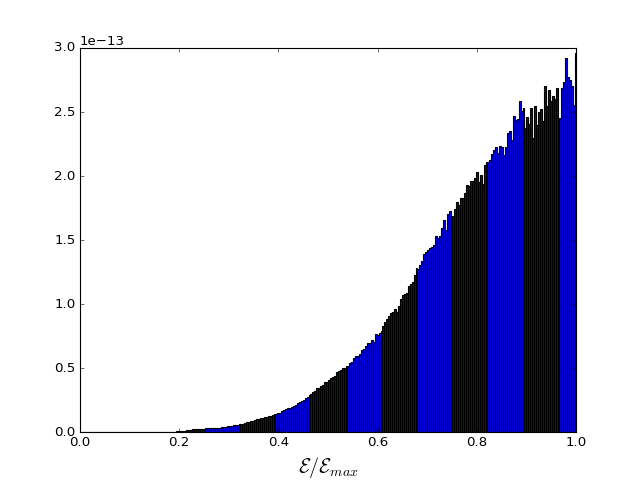

<Container object of 255 artists>

In [64]:
fig,ax = plt.subplots()
ax.set_xlim([0,1])
#ax.set_xlabel('r[kpc]',fontsize=18)
ax.set_xlabel(r'$\mathcal{E}/\mathcal{E}_{max}$',fontsize=18)
k_corr = fK_of_E_(bins_c)
ax.bar(bins_c/e_max,hist_ep/k_corr,width=bins_width/e_max)

In [65]:
qfile = open("../Simulations/Q_param.txt")
qzj17 = qsh04 = K_halo = U_halo = mod = M_200 = Simname = np.array([])
for l in qfile:
    if l[0]=="#":
        continue
    row = l.split(',')
    qzj17 = np.append(qzj17, float(row[0]))
    qsh04 = np.append(qsh04, float(row[1]))
    K_halo = np.append(K_halo, float(row[2]))
    U_halo = np.append(U_halo, float(row[3]))
    mod = np.append(mod, float(row[4]))
    M_200 = np.append(M_200, float(row[5]))
    Simname = np.append(Simname, row[6][:-1])

                      

<IPython.core.display.Javascript object>


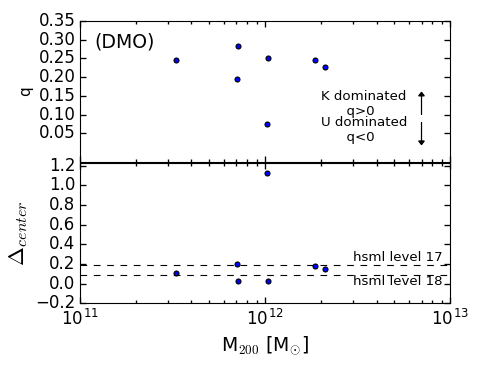

In [66]:
fig, [ax,ax1] = plt.subplots(2,1,gridspec_kw = {'height_ratios':[1, 1]},figsize=[6,4.6],sharex=True)
ax.set_ylabel(r"q",fontsize=0.8*font)
ax.set_xscale('log')
ax.set_xlim([1e11,1e13])
ax.set_ylim([-0.025,.35])
ax.set_yticks(np.arange(0.05,0.4,0.05))
ax.scatter(M_200,qzj17)
ax.arrow( 7e12, 0.08, 0.0, -0.05, fc="k", ec="k",head_width=5e11, head_length=0.01 )
ax.text(2e12, 0.03,"U dominated\n      q<0")
ax.arrow( 7e12, 0.1, 0.0, 0.05, fc="k", ec="k",head_width=5e11, head_length=0.01 )
ax.text(2e12, 0.1,"K dominated\n      q>0")
ax1.set_ylim([-0.2,1.23])
ax1.set_xlabel(r"M$_{200}$ [M$_{\odot}$]",fontsize=font)
ax1.set_ylabel(r"$\Delta_{center}$",fontsize=1.2*font)
ax1.axhline(y=0.190,color='k',linestyle='--')
ax1.axhline(y=0.090,color='k',linestyle='--')
ax1.scatter(M_200,mod)
ax1.text(3e12,-0.01,'hsml level 18')
ax1.text(3e12,0.23,'hsml level 17')
ax.text(1.2e11,0.28,"(DMO)", fontsize=font)
fig.tight_layout(h_pad=-0.19)
ax.tick_params(axis='both', which='major', labelsize=15, size=5,width=1.2)
ax.tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)
ax1.tick_params(axis='both', which='major', labelsize=15, size=5,width=1.2)
ax1.tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)
plt.savefig("/home/arturo/Documents/git/LAMtoLUPM_latex/Qparam.png",dpi=300)

In [67]:
get_mat =  np.vectorize(nbe.m_matrix_for_r)

In [70]:
#r = np.logspace(np.log10(myhalo.gs.hsml.min()),np.log10(2*myhalo.r200),15)
r = np.linspace(myhalo.gs.hsml.min(),2*myhalo.r200,300)
M_dm = np.array([nbe.m_matrix_for_r(myhalo,'halo',i) for i in r])
M_st = np.array([nbe.m_matrix_for_r(myhalo,'stars',i) for i in r])
a_dm, b_dm, c_dm = np.sqrt(M_dm[:,0,0]), np.sqrt(M_dm[:,1,1]), np.sqrt(M_dm[:,2,2])
a_st, b_st, c_st = np.sqrt(M_st[:,0,0]), np.sqrt(M_st[:,1,1]), np.sqrt(M_st[:,2,2])
S_dm = c_dm/a_dm
T_dm = ((a_dm**2) - (b_dm**2))/((a_dm**2) -(c_dm**2)) 
S_st = c_st/a_st
T_st = ((a_st**2) - (b_st**2))/((a_st**2) -(c_st**2)) 

KeyboardInterrupt: 

In [71]:
fig, ax = plt.subplots()
#ax.set_xlim(4,250)
ax.set_ylim(0,1.18)
ax.set_xlim(0,300)
ax.set_xlabel('r [kpc]',fontsize=font)
ax.plot([4,5],[1e3,2e3],color='gray',linestyle='--',lw=2,label="S")
ax.plot([4,5],[1e3,2e3],color='gray',linestyle='-',lw=2,label="T")
ax.plot(r,T_dm,'-',color='#155c9e',lw=2,label="Dark matter")
ax.plot(r,S_dm,'--',color='#155c9e',lw=2)
ax.plot(r,T_st,'-',color='#a91e4f',lw=2,label='stars')
ax.plot(r,np.sqrt(S_st),'--',color='#a91e4f',lw=2)
ax.axvline(x=myhalo.r200,color='k',linestyle='-.')
ax.text(myhalo.r200+2,0.2,r"R$_{200}$",fontsize=font)
ax.axvline(x=myhalo.r97,color='k',linestyle='-.')
ax.text(myhalo.r97+2,0.2,r"R$_{97}$",fontsize=font)


legend = ax.legend(loc='upper right', ncol=2, shadow=False, fontsize=font)
frame = legend.get_frame()
ax.tick_params(axis='both', which='major', labelsize=15, size=5,width=1.2)
ax.tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)
plt.savefig("/home/arturo/Documents/git/LAMtoLUPM_latex/T_and_S.pdf")

<IPython.core.display.Javascript object>

NameError: name 'T_dm' is not defined

In [ ]:
"""
r = np.logspace(np.log10(myhalo.gs.hsml.min()),np.log10(2*myhalo.r200),300)
M_dm = np.array([nbe.m_matrix_for_r(myhalo,'halo',i) for i in r])
M_st = np.array([nbe.m_matrix_for_r(myhalo,'stars',i) for i in r])
a_dm, b_dm, c_dm = M_dm[:,0,0], M_dm[:,1,1], M_dm[:,2,2]
a_st, b_st, c_st = M_st[:,0,0], M_st[:,1,1], M_st[:,2,2]
S_dm = c_dm/a_dm
T_dm = ((a_dm**2) - (b_dm**2))/((a_dm**2) -(c_dm**2)) 
S_st = c_st/a_st
T_st = ((a_st**2) - (b_st**2))/((a_st**2) -(c_st**2)) 
"""

In [ ]:
"""
fig, ax = plt.subplots()
#ax.set_xlim(4,250)
ax.set_ylim(0,1)
ax.set_xscale('log')
ax.plot(r,T_dm,'-',color='#155c9e',lw=2)
ax.plot(r,S_dm,'--',color='#155c9e',lw=2)
ax.plot(r,T_st,'-',color='#a91e4f',lw=2)
ax.plot(r,S_st,'--',color='#a91e4f',lw=2)
ax.axvline(x=myhalo.r200,color='k',linestyle='-.')
ax.text(0.05,170,r"R$_{200}$",fontsize=font)
"""


# $\beta$ parameter

$$\beta = 1 - \frac{ \sigma_{\phi}^2 + \sigma_{\theta}^2}{2 \sigma_{r}^2}$$

In [72]:
point_num = 150
r_beta = np.logspace(-1,np.log10(4*myhalo.r200),point_num)
vphi = np.concatenate((myhalo.dm.vphi,myhalo.st.vphi,myhalo.gs.vphi))
vtheta = np.concatenate((myhalo.dm.vtheta,myhalo.st.vtheta,myhalo.gs.vtheta))
vr = np.concatenate((myhalo.dm.vr,myhalo.st.vr,myhalo.gs.vr))

In [73]:
def beta_param(i):
    condition = np.where((r2>r_beta[i]**2)&(r2<=r_beta[i+1]**2))
    v_r = vr[condition]
    v_phi = vphi[condition]
    v_theta = vtheta[condition]
    #print (np.std(v_phi))**2 ,(np.std(v_theta))**2 , (np.std(v_r))**2  
    return 1 - ((np.std(v_phi))**2 +(np.std(v_theta))**2) / 2. / (np.std(v_r))**2  

get_beta = np.vectorize(beta_param)

In [74]:
beta_r = get_beta(range(point_num-1))

In [75]:
def beta_param_2(i):
    condition = np.where((r2>r_beta[i]**2)&(r2<=r_beta[i+1]**2))
    v_r = vr[condition]
    v_phi = vphi[condition]
    v_theta = vtheta[condition]
    #print (np.std(v_phi))**2 ,(np.std(v_theta))**2 , (np.std(v_r))**2  
    return 1 - (np.mean(v_phi**2) + np.mean(v_theta**2)) / 2. / (np.mean(v_r**2 )) 

get_beta_2 = np.vectorize(beta_param_2)

In [76]:
beta_r_2 = get_beta_2(range(point_num-1))

In [77]:
def beta_param_3(i):
    condition = np.where((r2>r_beta[i]**2)&(r2<=r_beta[i+1]**2))
    v_r = vr[condition]
    v_phi = vphi[condition]
    v_theta = vtheta[condition]
    #print (np.std(v_phi))**2 ,(np.std(v_theta))**2 , (np.std(v_r))**2  
    return 1 - ((np.mean(v_phi)**2) + (np.mean(v_theta)**2)) / 2. / (np.mean(v_r)**2 ) 
get_beta_3 = np.vectorize(beta_param_3)

In [78]:
beta_r_3 = get_beta_3(range(point_num-1))

<IPython.core.display.Javascript object>


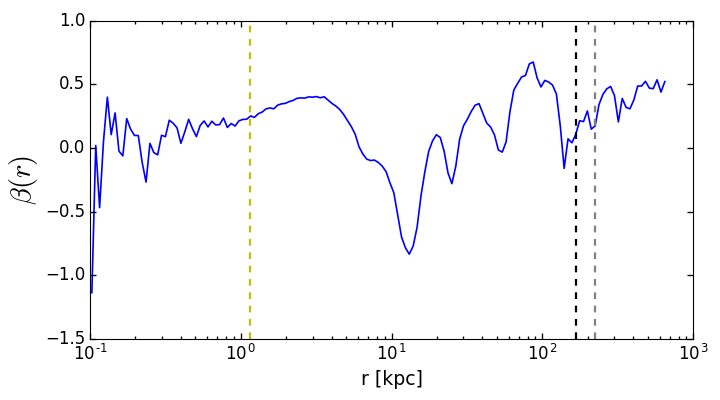

In [80]:
fig, ax = plt.subplots(figsize=[9,5])
r_2 = 6.95
ax.set_xscale('log')
#ax.set_title(r"$\beta(r)$ parameter", fontsize=1.5*font)
ax.set_xlabel(r"r [kpc]",fontsize=font)
ax.set_ylabel(r"$\beta(r)$",fontsize=1.5*font)
ax.set_ylim([-1.5,1])
ax.plot((r_beta[1:]+r_beta[:-1])/2.,beta_r,lw=1.5)
#ax.plot((r_beta[1:]+r_beta[:-1])/2/r_2,beta_r_2,lw=1.5)
#ax.plot((r_beta[1:]+r_beta[:-1])/2/r_2,beta_r_3,lw=1.5)


ax.axvline(x=myhalo.r200, color='k',lw=2,linestyle='--')
ax.axvline(x=myhalo.r97, color='gray',lw=2,linestyle='--')

ax.axvline(x=8/r_2, color='y',linestyle='--',lw=2,label=r'r$_{\odot}$')
fig.tight_layout()
ax.tick_params(axis='both', which='major', labelsize=15, size=5,width=1.2)
ax.tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)
#plt.savefig("/home/arturo/Documents/git/LAMtoLUPM_latex/beta_r.png",dpi=300)

In [ ]:
def delta_beta(i):
    condition = np.where((r2>r_beta[i]**2)&(r2<=r_beta[i+1]**2))
    v_r = vr[condition]
    v_phi = vphi[condition]
    v_theta = vtheta[condition]
    first = (np.std(v_phi**2))**2 / 4./ np.mean(v_phi**2)**2
    secon = (np.std(v_theta**2))**2 / 4./ np.mean(v_theta**2)**2 
    third = ((np.mean(v_phi**2) + np.mean(v_theta**2))**2)  * np.std(v_r**2)**2 / 2. / np.mean(v_r**2)**2 
    return  first + secon + third 
get_deltabeta = np.vectorize(delta_beta) 

In [ ]:
deltabeta_r = get_deltabeta(range(point_num-1))

In [ ]:
fig, ax = plt.subplots()
r_2 = 6.95
ax.set_xscale('log')
ax.set_title(r"$\beta(r)$ parameter", fontsize=22)
ax.set_xlabel(r"r / r$_2$ ",fontsize=15)
ax.set_ylabel(r"$\beta(r)$",fontsize=18)
ax.set_ylim([-4,2])
ax.plot((r_beta[1:]+r_beta[:-1])/2/r_2,beta_r_2,'b',lw=1.3)
ax.plot((r_beta[1:]+r_beta[:-1])/2/r_2,beta_r_2+deltabeta_r,'b--',lw=1.1)
ax.plot((r_beta[1:]+r_beta[:-1])/2/r_2,beta_r_2-deltabeta_r,'b--',lw=1.1)
ax.fill_between((r_beta[1:]+r_beta[:-1])/2/r_2,
                 beta_r_2+deltabeta_r, beta_r_2-deltabeta_r,color='b',alpha=0.2,label=r"$1 \sigma$")
ax.axvline(x=myhalo.r200/r_2, color='k',lw=2,linestyle='--',label=r'r$_{200}$')
#ax.axvline(x=myhalo.r97/r_2, color='gray',lw=2,linestyle='--',label=r'r$_{97}$')
#ax.axvline(x=np.sqrt(r_nei2)/r_2, color='g',lw=2,linestyle='--',label=r'first neighbourg')
#ax.axvline(x=8/r_2, color='y',linestyle='--',lw=2,label=r'r$_{\odot}$')

legend = ax.legend(loc='lower center', ncol=4, shadow=False, fontsize=14)
frame = legend.get_frame()
plt.savefig("/home/arturo/Documents/LAM/LAM2LUPM/report07-17/HaloB/Beta_param.pdf",dpi=300)

In [ ]:
fig, ax = plt.subplots()
r_2 = 6.95
ax.set_xscale('log')
ax.set_title(r"$\beta(r)$ parameter", fontsize=22)
ax.set_xlabel(r"r / r$_2$ ",fontsize=15)
ax.set_ylabel(r"$\beta(r)$",fontsize=18)
ax.set_ylim([-4,2])
ax.plot((r_beta[1:]+r_beta[:-1])/2/r_2,beta_r,'k',lw=1.2,
        label=r"$\beta_1$")
ax.plot((r_beta[1:]+r_beta[:-1])/2/r_2,beta_r_2,'b',lw=1.2,label=r"$\beta_2$")
ax.plot((r_beta[1:]+r_beta[:-1])/2/r_2,beta_r_2+deltabeta_r,'b--',lw=1.1)
ax.plot((r_beta[1:]+r_beta[:-1])/2/r_2,beta_r_2-deltabeta_r,'b--',lw=1.1)
ax.fill_between((r_beta[1:]+r_beta[:-1])/2/r_2,
                 beta_r_2+deltabeta_r, beta_r_2-deltabeta_r,color='b',alpha=0.2,label=r"$\beta_2 \pm 1 \sigma$")

beta1 = r"$\beta_1 = 1 - \frac{ \sigma_{\phi}^2 + \sigma_{\theta}^2}{2 \sigma_{r}^2}$"
ax.text(0.08,-2.5,beta1,fontsize=15)
beta2 = r"$\beta_2 = 1 - \frac{ <v_{\phi}^2> + <v_{\theta}^2>}{2 <v_{r}^2>}$"
ax.text(1.,-2.5,beta2,fontsize=15)

#ax.axvline(x=myhalo.r200/r_2, color='k',lw=2,linestyle='--',label=r'r$_{200}$')
#ax.axvline(x=myhalo.r97/r_2, color='gray',lw=2,linestyle='--',label=r'r$_{97}$')
#ax.axvline(x=np.sqrt(r_nei2)/r_2, color='g',lw=2,linestyle='--',label=r'first neighbourg')
#ax.axvline(x=8/r_2, color='y',linestyle='--',lw=2,label=r'r$_{\odot}$')

legend = ax.legend(loc='lower center', ncol=4, shadow=False, fontsize=14)
frame = legend.get_frame()
plt.savefig("/home/arturo/Documents/LAM/LAM2LUPM/report07-17/HaloB/Beta_paramB1vsB2.pdf",dpi=300)

# F(v) moments

In [ ]:
def moments(rmin,rmax):
    selection= np.where((myhalo.dm.r>rmin)&(myhalo.dm.r<=rmax))
    fdv, vs = np.histogram(myhalo.dm.v[selection],bins=50,normed=1)
    vcenter = (vs[:-1]+vs[1:])/2.
    m1 = simps(vcenter*fdv,x=vcenter)
    m2 = simps((vcenter**2)*fdv,x=vcenter)
    m3 = simps((vcenter**3)*fdv,x=vcenter)

    return m1,m2,m3

fdv_moments = np.vectorize(moments)


In [ ]:
r_v = np.logspace(np.log10(4*myhalo.gs.hsml.min()),np.log10(3*myhalo.r200),150)
m1,m2,m3 = fdv_moments(r_v[:-1],r_v[1:])

In [ ]:

fig, ax = plt.subplots(3,1)
ax[2].set_xlabel('r [kpc]',fontsize=18)
ax[0].set_ylabel('[km/s]',fontsize=18)
ax[1].set_ylabel(r'[km/s]$^2$',fontsize=18)
ax[2].set_ylabel(r'[km/s]$^3$',fontsize=18)
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[2].set_xscale('log')
ax[0].set_ylim([52,400])
ax[1].set_ylim([1e4,1.5e5])
ax[2].set_ylim([1e4,6.5e7])
ax[0].set_xlim([0.5,3*myhalo.r200])
ax[1].set_xlim([0.5,3*myhalo.r200])
ax[2].set_xlim([0.5,3*myhalo.r200])
ax[0].axvline(x=myhalo.r200,color='k',linestyle='--')
ax[1].axvline(x=myhalo.r200,color='k',linestyle='--')
ax[2].axvline(x=myhalo.r200,color='k',linestyle='--')
r_v_c = (r_v[:-1]+r_v[1:])/2.
ax[0].plot(r_v_c,m1)
ax[1].plot(r_v_c,m2)
ax[2].plot(r_v_c,m3)

fig.tight_layout(h_pad=-2.7)
ax[0].text(22,250,r'$\int_0 ^{v_{max}} v f(v) dv$',fontsize=17)
ax[1].text(22,70000,r'$\int_0 ^{v_{max}} v^2 f(v) dv$',fontsize=17)
ax[2].text(22,3e7,r'$\int_0 ^{v_{max}} v^3 f(v) dv$',fontsize=17)
ax[2].text(170,1e7,r'R$_{200}$',fontsize=17)


ax[0].tick_params(axis='y', which='major', labelsize=15, size=5,width=1.2)
ax[0].tick_params(axis='x', which='major', labelsize=0, size=5,width=1.2)
ax[0].tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)
ax[1].tick_params(axis='y', which='major', labelsize=15, size=5,width=1.2)
ax[1].tick_params(axis='x', which='major', labelsize=0, size=5,width=1.2)
ax[1].tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)
ax[2].tick_params(axis='both', which='major', labelsize=15, size=5,width=1.2)
ax[2].tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)
plt.savefig("/home/arturo/Documents/git/LAMtoLUPM_latex/moments.png",dpi=300)

    * histograms of f(v) at different radii with chi2 (Eddington vs. Maxwellian) - already done, except for the Maxwellian case.
    * vesc(r)+-dvesc at different radii + comparison with the value calculated from the potential, $\sqrt(-2\,\phi(r))$
    * beta(r)+-dbeta at different radii
    * compute the "equilibrium" test variable (ask Manu)

In [ ]:
limmin, limmax = 7.5,8.5
shell = (myhalo.dm.r>limmin)&(myhalo.dm.r<limmax)
disc = (np.abs(myhalo.dm.pos3d[:,2])<1.5)
nodisc = (np.abs(myhalo.dm.pos3d[:,2])>1.5)
v_disc_in_the_shell = myhalo.dm.v[shell&disc] 
v_nodisc_in_the_shell = myhalo.dm.v[shell&nodisc] 
bins = np.linspace(0,myhalo.dm.v[shell].max(),30)


In [ ]:
plt.figure()
plt.hist(v_disc_in_the_shell, bins, stacked=True)
plt.hist(v_nodisc_in_the_shell, bins, stacked=True)
print len(v_disc_in_the_shell)
print len(v_nodisc_in_the_shell)

In [ ]:
plt.figure()
plt.hist([v_disc_in_the_shell,v_nodisc_in_the_shell], bins, stacked=True, normed=True)
plt.show()

In [ ]:
nbe.real_center(myhalo.dm.pos3d,myhalo.dm.mass)